<a href="https://colab.research.google.com/github/psj03283/resume/blob/main/PAP(07_03)_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Library**

In [ ]:
!pip install -q tensorflow
!pip install efficientnet
!pip install tensorflow_addons

In [ ]:
import tensorflow as tf

In [ ]:
from tqdm import tqdm_notebook
ram=[]
for i in tqdm_notebook(range(100)):
  ram.append("randomword"*i)

/tmp/ipython-input-49-2252751400.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(100)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.python.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm
#import tensorflow_addons as tfa
import openpyxl

In [ ]:
SEED = 42
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Dataset Loading**

In [ ]:
import pandas as pd
import os
import glob

# Initialize empty DataFrame
df = pd.DataFrame(columns=['paths', 'disease'])

# Class map
class_dirs = {
    0: '/content/drive/My Drive/pap_smear/NILM',
    1: '/content/drive/My Drive/pap_smear/LSIL',
    2: '/content/drive/My Drive/pap_smear/HSIL',
    3: '/content/drive/My Drive/pap_smear/SCC'
}

total_count = 0
for label, dir_path in class_dirs.items():
    filepaths = glob.glob(os.path.join(dir_path, '*'))
    print(f"🗂️  Found {len(filepaths)} images in class {label} ({os.path.basename(dir_path)})")

    temp_df = pd.DataFrame({
        'paths': filepaths,
        'disease': label
    })
    df = pd.concat([df, temp_df], ignore_index=True)
    total_count += len(filepaths)

print("\n✅ Total images loaded:", total_count)


🗂️  Found 612 images in class 0 (NILM)
🗂️  Found 113 images in class 1 (LSIL)
🗂️  Found 163 images in class 2 (HSIL)
🗂️  Found 74 images in class 3 (SCC)

✅ Total images loaded: 962


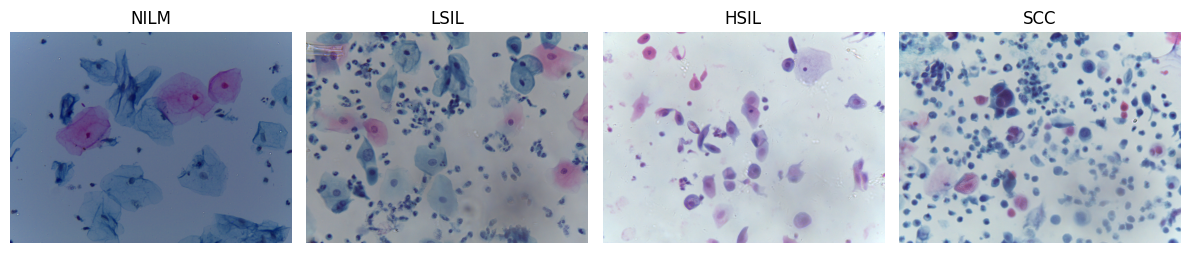

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Class names for labeling
class_names = {0: 'NILM', 1: 'LSIL', 2: 'HSIL', 3: 'SCC'}

# Set up a plot
plt.figure(figsize=(12, 6))

# Show one **random** image per class
for idx, label in enumerate(sorted(df['disease'].unique())):
    # Randomly sample one row for this class
    sample_path = df[df['disease'] == label].sample(1)['paths'].iloc[0]

    # Read and convert image
    img = cv2.imread(sample_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot
    plt.subplot(1, 4, idx + 1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()


## **Dataset Partitioning**

In [ ]:
df['disease'] = df['disease'].astype(int)


In [ ]:
from sklearn.model_selection import StratifiedKFold
import shutil

# Your data
X = df['paths'].values
y = df['disease'].values

# Setup CV splitter
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

fold_root = '/content/drive/My Drive/pap_smear/folds/'

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n📂 Fold {fold}:")

    # Make fold directories
    train_dir = os.path.join(fold_root, f'fold{fold}/train/')
    val_dir   = os.path.join(fold_root, f'fold{fold}/val/')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Get splits
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df   = df.iloc[val_idx].reset_index(drop=True)

    print(f"  Train size: {len(train_df)}, Val size: {len(val_df)}")

    # For each split: copy images into fold folders, organized by class
    for split_df, split_dir in zip([train_df, val_df], [train_dir, val_dir]):
        for _, row in split_df.iterrows():
            label = row['disease']
            src_path = row['paths']
            filename = os.path.basename(src_path)

            label_dir = os.path.join(split_dir, str(label))
            os.makedirs(label_dir, exist_ok=True)

            dst_path = os.path.join(label_dir, filename)
            shutil.copy2(src_path, dst_path)
train_df.to_csv(os.path.join(fold_root, f'fold{fold}_train.csv'), index=False)
val_df.to_csv(os.path.join(fold_root, f'fold{fold}_val.csv'), index=False)


📂 Fold 1:
  Train size: 721, Val size: 241

📂 Fold 2:
  Train size: 721, Val size: 241

📂 Fold 3:
  Train size: 722, Val size: 240

📂 Fold 4:
  Train size: 722, Val size: 240


##**color deconvolution (H,E,DAB)**

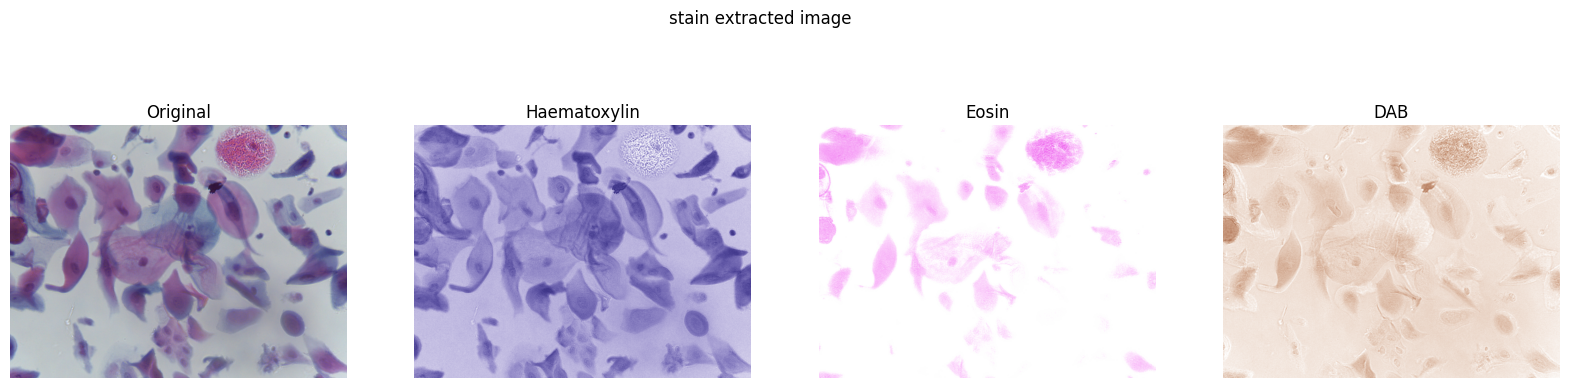

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load image
image_path = '/content/drive/My Drive/pap_smear/SCC/scc_1 (11).jpg'
pos_img_bgr = cv2.imread(image_path)
pos_img_rgb = cv2.cvtColor(pos_img_bgr, cv2.COLOR_BGR2RGB)

# Your Pap stain matrix (example)
pap_matrix = np.array([
    [0.18, 0.01, 0.1],  # R
    [0.2, 0.13, 0.21],  # G
    [0.08, 0.01, 0.29],  # B
]).T  # shape (3, 3)

channels = ['Haematoxylin', 'Eosin', 'DAB']


pos_img_bright = np.clip(pos_img_rgb * 1, 0, 255).astype(np.uint8)

# Normalize for OD
rgb_norm = pos_img_bright / 255.0 + 1e-8  # avoid log(0)
OD = -np.log(rgb_norm)

# Separate stains
stains_OD = np.dot(OD, np.linalg.inv(pap_matrix))

# Reconstruct each stain (grayscale, no extra hue)
reconstructed_rgb = []
for i in range(3):
    only_one_OD = np.zeros_like(stains_OD)
    only_one_OD[:, :, i] = stains_OD[:, :, i]
    OD_recon = np.dot(only_one_OD, pap_matrix)
    rgb_recon = np.exp(-OD_recon)
    rgb_recon = np.clip(rgb_recon, 0, 1)
    reconstructed_rgb.append(rgb_recon)

# Show results
plt.figure(figsize=(20, 5))
plt.suptitle('stain extracted image')

plt.subplot(1, 4, 1)
plt.imshow(pos_img_bright)
plt.title('Original')
plt.axis('off')

for i in range(3):
    plt.subplot(1, 4, i+2)
    plt.imshow(reconstructed_rgb[i])
    plt.title(channels[i])
    plt.axis('off')

plt.show()


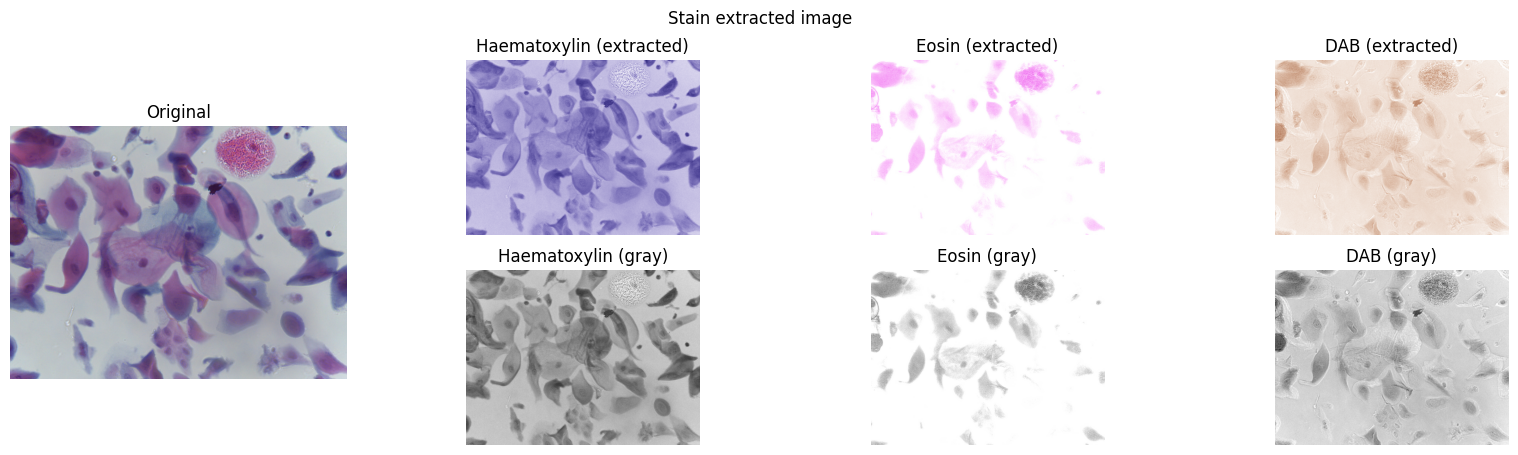

In [ ]:
# Show results with extracted stains and grayscale version
plt.figure(figsize=(20, 5))
plt.suptitle('Stain extracted image')

plt.subplot(1, 4, 1)
plt.imshow(pos_img_bright)
plt.title('Original')
plt.axis('off')

for i in range(3):
    plt.subplot(2, 4, i+2)
    plt.imshow(reconstructed_rgb[i])
    plt.title(f"{channels[i]} (extracted)")
    plt.axis('off')

    plt.subplot(2, 4, i+6)
    plt.imshow(reconstructed_rgb[i].mean(axis=2), cmap='gray')
    plt.title(f"{channels[i]} (gray)")
    plt.axis('off')

plt.show()


In [ ]:
import os
from matplotlib import pyplot as plt

# Output folder
output_root = '/content/drive/My Drive/pap_smear/paper_reference'
os.makedirs(output_root, exist_ok=True)

# === Save Original RGB ===
original_img = pos_img_bright  # already RGB uint8
original_path = os.path.join(output_root, f'scc_1_11_original.png')
plt.imsave(original_path, original_img)
print(f"✅ Saved: {original_path}")

# === Save Original Grayscale ===
original_gray = pos_img_bright.mean(axis=2) / 255.0  # normalize to [0,1]
original_gray_path = os.path.join(output_root, f'scc_1_11_original_gray.png')
plt.imsave(original_gray_path, original_gray, cmap='gray')
print(f"✅ Saved: {original_gray_path}")

# === Save each stain ===
for i in range(3):
    stain_name = channels[i]

    # RGB
    rgb_img = (reconstructed_rgb[i] * 255).astype(np.uint8)
    rgb_path = os.path.join(output_root, f'scc_1_11_{stain_name}_rgb.png')
    plt.imsave(rgb_path, rgb_img)

    # Grayscale
    gray_img = reconstructed_rgb[i].mean(axis=2)
    gray_path = os.path.join(output_root, f'scc_1_11_{stain_name}_gray.png')
    plt.imsave(gray_path, gray_img, cmap='gray')

    print(f"✅ Saved: {rgb_path}")
    print(f"✅ Saved: {gray_path}")


✅ Saved: /content/drive/My Drive/pap_smear/paper_reference/scc_1_11_original.png
✅ Saved: /content/drive/My Drive/pap_smear/paper_reference/scc_1_11_original_gray.png
✅ Saved: /content/drive/My Drive/pap_smear/paper_reference/scc_1_11_Haematoxylin_rgb.png
✅ Saved: /content/drive/My Drive/pap_smear/paper_reference/scc_1_11_Haematoxylin_gray.png
✅ Saved: /content/drive/My Drive/pap_smear/paper_reference/scc_1_11_Eosin_rgb.png
✅ Saved: /content/drive/My Drive/pap_smear/paper_reference/scc_1_11_Eosin_gray.png
✅ Saved: /content/drive/My Drive/pap_smear/paper_reference/scc_1_11_DAB_rgb.png
✅ Saved: /content/drive/My Drive/pap_smear/paper_reference/scc_1_11_DAB_gray.png


##**fold separation**

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# === Define your stain matrix ===
pap_matrix = np.array([
    [0.18, 0.01, 0.1],
    [0.2, 0.13, 0.21],
    [0.08, 0.01, 0.29],
]).T

channels = ['H', 'E', 'DAB']  # Order must match your matrix

root_fold_dir = '/content/drive/My Drive/pap_smear/folds/'

# === Loop over folds and splits ===
for fold in range(1, 5):
    for split in ['train', 'val']:
        input_dir = os.path.join(root_fold_dir, f'fold{fold}/{split}')

        for class_name in os.listdir(input_dir):
            class_input_dir = os.path.join(input_dir, class_name)

            for img_name in tqdm(os.listdir(class_input_dir), desc=f"Fold {fold} {split} {class_name}"):
                img_path = os.path.join(class_input_dir, img_name)

                # Load original RGB image
                img_bgr = cv2.imread(img_path)
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                img_float = img_rgb / 255.0 + 1e-8  # avoid log(0)

                # Convert to OD
                OD = -np.log(img_float)

                # Deconvolve stains
                stains_OD = np.dot(OD, np.linalg.inv(pap_matrix))

                # === For each stain: isolate + replicate to (stain, stain, stain) ===
                for i, stain in enumerate(channels):
                    only_one_OD = np.zeros_like(stains_OD)
                    only_one_OD[:, :, i] = stains_OD[:, :, i]

                    OD_recon = np.dot(only_one_OD, pap_matrix)
                    rgb_recon = np.exp(-OD_recon)
                    rgb_recon = np.clip(rgb_recon, 0, 1)

                    # Make single-channel and replicate to 3 channels
                    stain_single = rgb_recon.mean(axis=2, keepdims=True)
                    stain_triple = np.repeat(stain_single, 3, axis=2) * 255
                    stain_triple_uint8 = stain_triple.astype(np.uint8)

                    # Save to correct output folder
                    out_dir = os.path.join(root_fold_dir, f'fold{fold}_{stain}', split, class_name)
                    os.makedirs(out_dir, exist_ok=True)
                    out_path = os.path.join(out_dir, img_name)

                    cv2.imwrite(out_path, cv2.cvtColor(stain_triple_uint8, cv2.COLOR_RGB2BGR))


Fold 4 val 3: 100%|██████████| 18/18 [00:48<00:00,  2.72s/it]


##**Grayscale reverse**

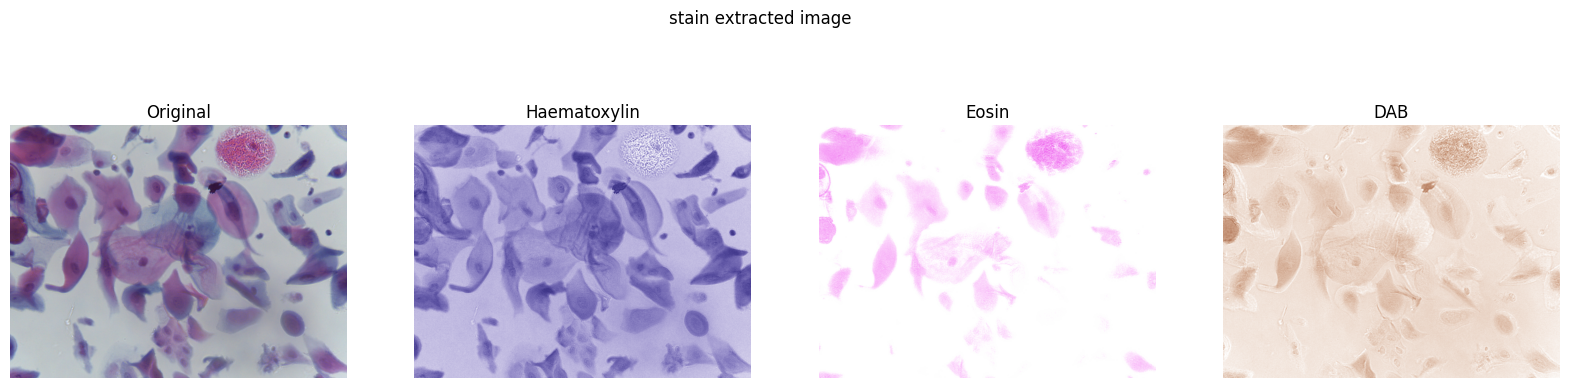

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load image
image_path = '/content/drive/My Drive/pap_smear/SCC/scc_1 (11).jpg'
pos_img_bgr = cv2.imread(image_path)
pos_img_rgb = cv2.cvtColor(pos_img_bgr, cv2.COLOR_BGR2RGB)

# Your Pap stain matrix (example)
pap_matrix = np.array([
    [0.18, 0.01, 0.1],  # R
    [0.2, 0.13, 0.21],  # G
    [0.08, 0.01, 0.29],  # B
]).T  # shape (3, 3)

channels = ['Haematoxylin', 'Eosin', 'DAB']


pos_img_bright = np.clip(pos_img_rgb * 1, 0, 255).astype(np.uint8)

# Normalize for OD
rgb_norm = pos_img_bright / 255.0 + 1e-8  # avoid log(0)
OD = -np.log(rgb_norm)

# Separate stains
stains_OD = np.dot(OD, np.linalg.inv(pap_matrix))

# Reconstruct each stain (grayscale, no extra hue)
reconstructed_rgb = []
for i in range(3):
    only_one_OD = np.zeros_like(stains_OD)
    only_one_OD[:, :, i] = stains_OD[:, :, i]
    OD_recon = np.dot(only_one_OD, pap_matrix)
    rgb_recon = np.exp(-OD_recon)
    rgb_recon = np.clip(rgb_recon, 0, 1)
    reconstructed_rgb.append(rgb_recon)

# Show results
plt.figure(figsize=(20, 5))
plt.suptitle('stain extracted image')

plt.subplot(1, 4, 1)
plt.imshow(pos_img_bright)
plt.title('Original')
plt.axis('off')

for i in range(3):
    plt.subplot(1, 4, i+2)
    plt.imshow(reconstructed_rgb[i])
    plt.title(channels[i])
    plt.axis('off')

plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# === Create output folder if needed ===
output_root = '/content/drive/My Drive/pap_smear/paper_reference'
os.makedirs(output_root, exist_ok=True)

# === Loop through stains ===
for i in range(3):
    stain_name = channels[i]
    gray_img = reconstructed_rgb[i].mean(axis=2)

    # ✅ Stretch intensity for better contrast
    p1 = np.percentile(gray_img, 1)
    p99 = np.percentile(gray_img, 99)
    gray_img_stretched = np.clip(gray_img, p1, p99)
    gray_img_norm = (gray_img_stretched - p1) / (p99 - p1 + 1e-8)

    # === Save each grayscale stain individually ===
    save_path = os.path.join(output_root, f'scc_1_11_{stain_name}_gray_boosted.png')

    plt.imsave(save_path, gray_img_norm, cmap='gray_r')  # 'gray_r' = white structures, black bg

    print(f"✅ Saved: {save_path}")


✅ Saved: /content/drive/My Drive/pap_smear/paper_reference/scc_1_11_Haematoxylin_gray_boosted.png
✅ Saved: /content/drive/My Drive/pap_smear/paper_reference/scc_1_11_Eosin_gray_boosted.png
✅ Saved: /content/drive/My Drive/pap_smear/paper_reference/scc_1_11_DAB_gray_boosted.png


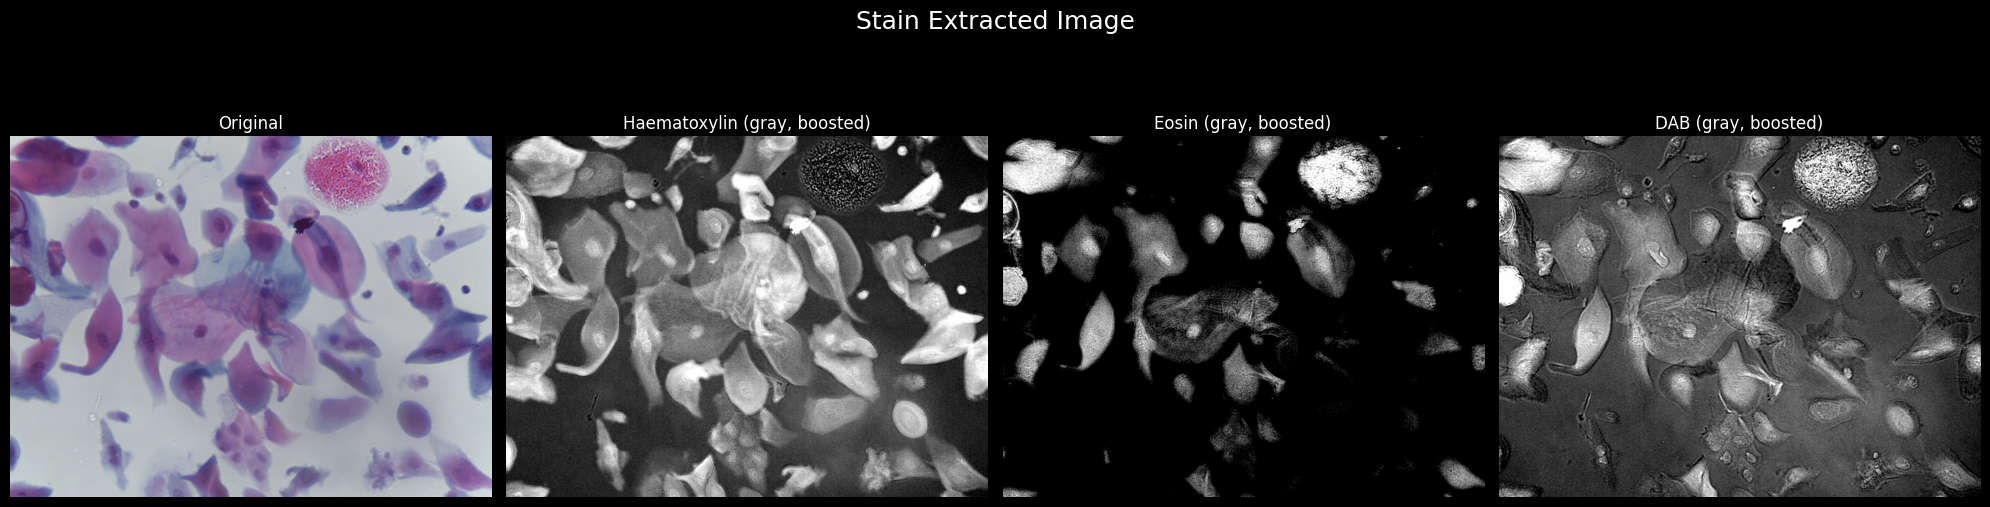

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 6))
plt.suptitle('Stain Extracted Image', fontsize=18)

# === Original image ===
plt.subplot(1, 4, 1)
plt.imshow(pos_img_bright)
plt.title('Original')
plt.axis('off')

# === Extracted stains: Grayscale only, boosted ===
for i in range(3):
    gray_img = reconstructed_rgb[i].mean(axis=2)

    # ✅ Stretch intensity for better contrast
    p1 = np.percentile(gray_img, 1)
    p99 = np.percentile(gray_img, 99)
    gray_img_stretched = np.clip(gray_img, p1, p99)
    gray_img_norm = (gray_img_stretched - p1) / (p99 - p1 + 1e-8)

    # === Show boosted stain ===
    plt.subplot(1, 4, i + 2)
    plt.imshow(gray_img_norm, cmap='gray_r')
    plt.title(f"{channels[i]} (gray, boosted)")
    plt.axis('off')

plt.tight_layout()
plt.show()